In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from IPython.display import Image

In [2]:
# Loading the dataset from a CSV file into a Pandas DataFrame
data_df = pd.read_csv("./world sustainability data.csv")

# Displaying the first five rows of the DataFrame to get an overview of the data
data_df.head()


,Country Name,Country Code,Year,Access to electricity (% of population) - EG.ELC.ACCS.ZS,Adjusted net national income per capita (annual % growth) - NY.ADJ.NNTY.PC.KD.ZG,"Adjusted net savings, excluding particulate emission damage (% of GNI) - NY.ADJ.SVNX.GN.ZS",Adjusted savings: carbon dioxide damage (% of GNI) - NY.ADJ.DCO2.GN.ZS,Adjusted savings: natural resources depletion (% of GNI) - NY.ADJ.DRES.GN.ZS,Adjusted savings: net forest depletion (% of GNI) - NY.ADJ.DFOR.GN.ZS,Adjusted savings: particulate emission damage (% of GNI) - NY.ADJ.DPEM.GN.ZS,...,Gini index (World Bank estimate) - SI.POV.GINI,Income Classification (World Bank Definition),Individuals using the Internet (% of population) - IT.NET.USER.ZS,"Life expectancy at birth, total (years) - SP.DYN.LE00.IN","Population, total - SP.POP.TOTL",Regime Type (RoW Measure Definition),Rural population (% of total population) - SP.RUR.TOTL.ZS,Total natural resources rents (% of GDP) - NY.GDP.TOTL.RT.ZS,Urban population (% of total population) - SP.URB.TOTL.IN.ZS,World Regions (UN SDG Definition)
0,Aruba,ABW,2000,91.660398,NaN,15.392211,2.389134,0.000190,0.000190,NaN,...,NaN,High income,NaN,NaN,NaN,NaN,53.283,NaN,NaN,Latin America and Caribbean
1,Aruba,ABW,2001,100.000000,NaN,11.491930,2.509046,0.000214,0.000214,NaN,...,NaN,High income,17.1,73.853,92892.0,NaN,53.661,0.000712,46.339,Latin America and Caribbean
2,Aruba,ABW,2002,100.000000,NaN,3.893620,2.721385,0.000223,0.000223,NaN,...,NaN,High income,18.8,73.937,94992.0,NaN,54.028,0.000657,45.972,Latin America and Caribbean
3,Aruba,ABW,2003,100.000000,NaN,6.713863,2.733676,0.000243,0.000243,NaN,...,NaN,High income,20.8,74.038,97016.0,NaN,54.394,0.000700,45.606,Latin America and Caribbean
4,Aruba,ABW,2004,100.000000,NaN,9.801576,2.678363,0.000256,0.000256,NaN,...,NaN,High income,23.0,74.156,98744.0,NaN,54.760,0.000685,45.240,Latin America and Caribbean


In [3]:
# --- Define old and new column names ---
old_column_names = [
    "Country Name", 
    "Year", 
    "Access to electricity (% of population) - EG.ELC.ACCS.ZS",
    "Proportion of seats held by women in national parliaments (%) - SG.GEN.PARL.ZS",
    "Individuals using the Internet (% of population) - IT.NET.USER.ZS",
    "Prevalence of undernourishment (%) - SN_ITK_DEFC - 2.1.1",
    'Population, total - SP.POP.TOTL'
]
new_column_names = ["country", "year", "electricity", "women", "internet", "undernourishment", "population"]
rename_dict = dict(zip(old_column_names, new_column_names))

In [4]:
# --- Rename columns and select only the renamed columns of interest ---
data_df.rename(columns=rename_dict, inplace=True)
data_df = data_df[new_column_names]


In [5]:
def linear_function(x, a, b):
    """
    A simple linear function.
    
    Parameters:
    x (float): The independent variable.
    a (float): The slope of the line.
    b (float): The y-intercept of the line.

    Returns:
    float: The dependent variable.
    """
    return a * x + b

In [6]:
# --- Define variables for analysis ---
variable_names = ["electricity", "women", "internet", "undernourishment"]

# --- Calculate weighted values ---
variable_df = data_df[variable_names].mul(data_df["population"], axis=0)

# --- Create new DataFrame with weighted values ---
avg_data_df = data_df.copy()
avg_data_df[variable_names] = variable_df

# --- Calculate per-capita values ---
world_evolution_df = avg_data_df.groupby(by='year').mean(numeric_only=True)
world_evolution_df = world_evolution_df.div(world_evolution_df["population"], axis=0)

# --- Remove unnecessary data ---
world_evolution_df.drop(index=2000, columns="population", inplace=True)

# --- Reset DataFrame index ---
world_evolution_df.reset_index(inplace=True)

world_evolution_df

,year,electricity,women,internet,undernourishment
0,2001,82.569428,14.651764,8.264923,18.932399
1,2002,82.758835,15.891407,10.811117,19.124977
2,2003,83.381083,14.916249,12.881269,19.005063
3,2004,82.654145,14.961672,14.645758,19.178962
4,2005,82.423633,15.741065,16.283153,19.063426
5,2006,82.908941,15.640012,18.029877,17.641826
6,2007,82.844727,16.248243,20.595190,16.700995
7,2008,83.390435,16.678637,23.298089,15.844852
8,2009,83.692919,17.902040,25.858772,15.204364
9,2010,84.616386,18.010044,29.148391,14.001446


In [7]:
# --- Fit linear function to data and calculate R-squared ---
start_year = 2001
end_year = 2019
x_values = np.array(range(start_year, end_year))
y_values = world_evolution_df['undernourishment'].values

optimal_params, param_covariance = curve_fit(linear_function, x_values, y_values)
predicted_y = linear_function(x_values, *optimal_params)

residuals = y_values - predicted_y
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_values - np.mean(y_values))**2)

r_squared = 1 - (ss_res / ss_tot)

In [8]:
r_squared

0.9026112911782519

In [9]:
# Define dictionary to store future predictions
global_predictions = {"year": np.array(range(2001, 2102, 1))}


# Iterate over each variable for analysis
for variable in variable_names:
    # Remove NA values for the current variable
    variable_evolution_df = world_evolution_df[["year", variable]].dropna()

    # Fit the linear function to the data
    optimal_params, _ = curve_fit(linear_function, variable_evolution_df["year"], variable_evolution_df[variable])
    
    # Make predictions for future years
    fit_predictions = linear_function(global_predictions["year"], *optimal_params)
    
    # Define goal for each variable
    goal = 50 if variable == "women" else 0 if variable == "undernourishment" else 100

    # Calculate when the goal will be reached
    try:
        goal_index = np.where((fit_predictions >= goal) if goal else (fit_predictions <= goal))
        goal_index = goal_index[0][0]
        goal_year = global_predictions["year"][goal_index] - 1
    except IndexError:
        goal_index = -1
        goal_year = None

    # Store results in dictionary
    global_predictions[variable] = {"fit": fit_predictions, "goal_index": goal_index, "goal_year": goal_year}

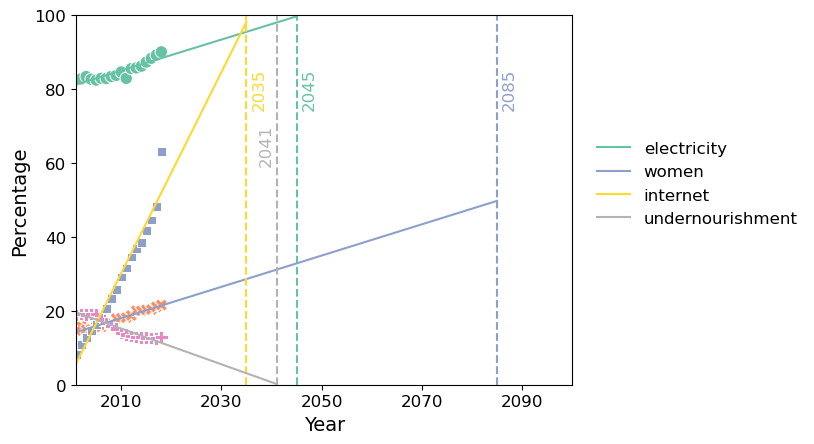

In [10]:
# Plot the data
sns.scatterplot(data=world_evolution_df.set_index("year"), s=80, palette="Set2", legend=False)

x_values = global_predictions["year"]
colors = iter(plt.cm.Set2(np.linspace(0, 1, len(variable_names))))

# Plot the predictions for each variable and mark the goal achievement year
for variable in variable_names:
    y_values = global_predictions[variable]["fit"]
    goal_index = global_predictions[variable]["goal_index"]
    goal_year = global_predictions[variable]["goal_year"]
    
    color = next(colors)
    plt.plot(x_values[:goal_index], y_values[:goal_index], color=color, label=variable)
    if goal_year is not None:
        plt.vlines(goal_year, 0, 100, colors=color, linestyles="dashed")
        h_shift = 1 if variable != "undernourishment" else -3.5
        v_shift = 0 if variable != "undernourishment" else -15
        plt.text(goal_year + h_shift, 75 + v_shift, f"{goal_year}", fontsize=12, color=color, rotation=90)

# Customize the plot
plt.xticks(ticks=[2010, 2030, 2050, 2070, 2090])
plt.xlim(2001, 2100)
plt.xlabel("Year", fontsize=14)

plt.ylim(0, 100)
plt.ylabel("Percentage", fontsize=14)

plt.tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.02, 0.7, 0.1, 0), loc="upper left", frameon=False, fontsize=12)
plt.show()


In [11]:
# Define a quadratic function for regression
def objective(x, a, b, c):
    return a * x**2 + b * x + c
    """
    A quadratic polynomial function.
    
    a (float): Coefficient of x squared. It determines the curvature of the parabola formed by the quadratic equation on a graph.
    b (float): Coefficient of x. It determines the slope of the line tangent to the vertex of the parabola.
    c (float): Constant term. It's the value of the polynomial when x = 0. In terms of the graph of the quadratic equation, it's the y-intercept.
    x (float): The variable input to the polynomial.

    Returns:
    float: The dependent variable.
    """

In [12]:
# Initialize a dictionary to store global prediction data
global_predictions = {"year": np.array(range(2001, 2102, 1))}

# Define a dictionary for the goal of each variable
goals = {"women": 50, "undernourishment": 0, "electricity": 100, "internet": 100}

# Loop through each variable
for variable in variable_names:
    # Drop NA values for the current variable
    variable_data = world_evolution_df[["year", variable]].dropna()

    # Fit the quadratic model to the data
    optimal_params, _ = curve_fit(objective, variable_data["year"], variable_data[variable])

    # Use the fitted model to predict future values
    fit = objective(global_predictions["year"], *optimal_params)

    # Get the goal for the current variable
    goal = goals.get(variable, 100)

    # Determine the year in which the goal will be reached
    try:
        goal_index = np.where((fit >= goal) if goal else (fit <= goal))[0][0]
        goal_year = global_predictions["year"][goal_index] - 1
    except IndexError:
        # If the goal cannot be reached, set the year and index to None
        goal_index = None
        goal_year = None
    global_predictions[variable] = {"fit": fit, "goal_index": goal_index, "goal_year": goal_year}

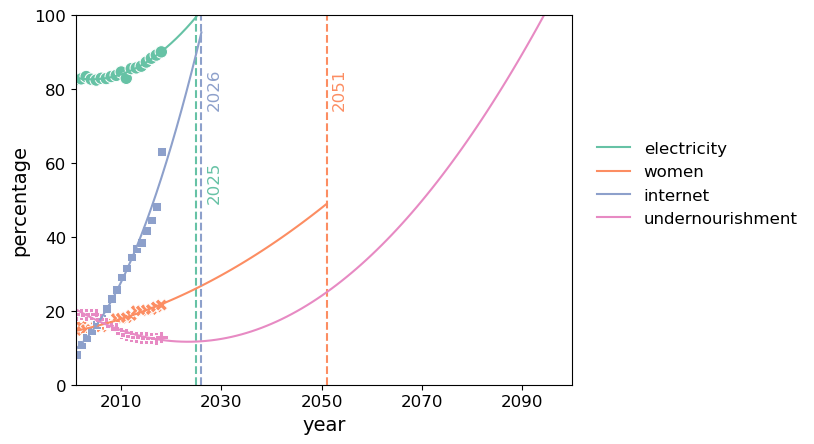

In [13]:
# Prepare the plot
sns.scatterplot(data=world_evolution_df.set_index("year"), s=80, palette="Set2", legend=False)

x = global_predictions["year"]
colors = iter(plt.cm.Set2(np.arange(len(variable_names))))

# Loop through each variable
for variable in variable_names:
    y = global_predictions[variable]["fit"]
    goal_index = global_predictions[variable]["goal_index"]
    goal_year = global_predictions[variable]["goal_year"]

    color = next(colors)

    # Plot the fitted data and the year the goal is expected to be reached
    plt.plot(x[:goal_index], y[:goal_index], color=color, label=variable)

    if goal_year is not None:
        plt.vlines(goal_year, 0, 100, colors=color, linestyles="dashed")

        # Adjust the position of the goal year text depending on the variable
        h_shift = 1 if variable != "undernourishment" else -3.5
        v_shift = 0 if variable != "undernourishment" else -15

        # Position the goal year text differently for the 'electricity' variable
        if variable == 'electricity':
            plt.text(goal_year + h_shift + 1, 50 + v_shift, str(goal_year), fontsize=12, color=color, rotation=90, horizontalalignment='left')
        else:
            plt.text(goal_year + h_shift, 75 + v_shift, str(goal_year), fontsize=12, color=color, rotation=90)

# Set the ticks, labels, and legend for the plot
plt.xticks(ticks=[2010, 2030, 2050, 2070, 2090])
plt.xlim(2001, 2100)
plt.xlabel("year", fontsize=14)

plt.ylim(0, 100)
plt.ylabel("percentage", fontsize=14)

plt.tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.02, 0.7), frameon=False, fontsize=12)

# Display the plot
plt.show()

In [14]:
# Define the x and y data points, which represent years and 'undernourishment' percentage respectively
x = np.array(range(2001, 2019, 1))
y = world_evolution_df['undernourishment'].values

# Fit the quadratic objective function to the data points, and get the optimal parameters
popt, _ = curve_fit(objective, x, y)

# Calculate the residuals which are the differences between actual y and predicted y
residuals = y - objective(x, *popt)

# Calculate the sum of squared residuals and the total sum of squares
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)

# Compute the R-squared value, which represents how well the fitted model explains the data variability
r_squared = 1 - (ss_res / ss_tot)


In [15]:
# Initialize the prediction dictionary and the year range
country_predict_dct = {"year": np.array(range(2001, 2202, 1))}
country_evolution_df = data_df.copy()

# Get the list of unique countries from the data
countries = country_evolution_df["country"].unique()

# Initialize an empty list to store R-squared values for each variable and each country
goal_yr_ls_ls = []

# Loop over each country
for country in countries:
    country_predict_dct[country] = {}
    country_filter = country_evolution_df["country"] == country

    # Initialize an empty list to store R-squared values for each variable
    goal_yr_ls = []

    # Loop over each variable
    for variable in variable_names:
        country_predict_dct[country][variable] = {}

        try:
            # Select the data for the current country and variable, removing rows with missing data
            variable_evolution_df = country_evolution_df[country_filter][["year", variable]].dropna()

            # Fit the linear model to the data and compute the residuals
            popt, _ = curve_fit(f=linear_function, xdata=variable_evolution_df["year"], ydata=variable_evolution_df[variable])
            residuals = variable_evolution_df[variable] - linear_function(variable_evolution_df["year"], *popt)

            # Compute the sum of squared residuals and the total sum of squares
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((variable_evolution_df[variable] - np.mean(variable_evolution_df[variable])) ** 2)

            # Compute the R-squared value if the total sum of squares is non-zero
            r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else None
        except (ValueError, TypeError):
            # If a ValueError or TypeError occurred (e.g., due to missing data), set the R-squared value to None
            r_squared = None

        # Append the R-squared value to the list for the current country
        goal_yr_ls.append(r_squared)

    # Append the list of R-squared values for the current country to the master list
    goal_yr_ls_ls.append(goal_yr_ls)

# Convert the master list into a DataFrame with one row per country and one column per variable
country_predict_df = pd.DataFrame(goal_yr_ls_ls, columns=variable_names, index=countries)

country_predict_df.head(20)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


,electricity,women,internet,undernourishment
Aruba,0.080602,NaN,0.968787,NaN
Angola,0.795406,0.587328,0.751370,0.907998
Albania,0.324554,0.905025,0.944248,0.469389
United Arab Emirates,NaN,0.691053,0.957020,0.298511
Argentina,0.969384,0.447207,0.975099,0.313747
Armenia,0.318886,0.855265,0.915172,0.747656
Antigua and Barbuda,0.150447,0.586169,0.995911,NaN
Australia,NaN,0.537486,0.969299,NaN
Austria,NaN,0.075418,0.892147,NaN
Azerbaijan,0.640180,0.828039,0.926609,0.992095


In [16]:
country_predict_df[(country_predict_df["undernourishment"] != 0)].sort_values(by="undernourishment").iloc[:20,]["undernourishment"]

Liberia                     0.001920
Mauritania                  0.012442
Iran, Islamic Rep.          0.017176
Rwanda                      0.019821
Jordan                      0.035006
Venezuela, RB               0.050112
Lebanon                     0.055458
Mauritius                   0.120105
Chile                       0.136847
Namibia                     0.154630
Central African Republic    0.158882
Cyprus                      0.180320
Lesotho                     0.219839
Eswatini                    0.235553
Madagascar                  0.238984
Mozambique                  0.249368
Vanuatu                     0.251040
Colombia                    0.251343
Malaysia                    0.253806
Slovak Republic             0.258872
Name: undernourishment, dtype: float64

y = -0.01070 * x + 120.40598


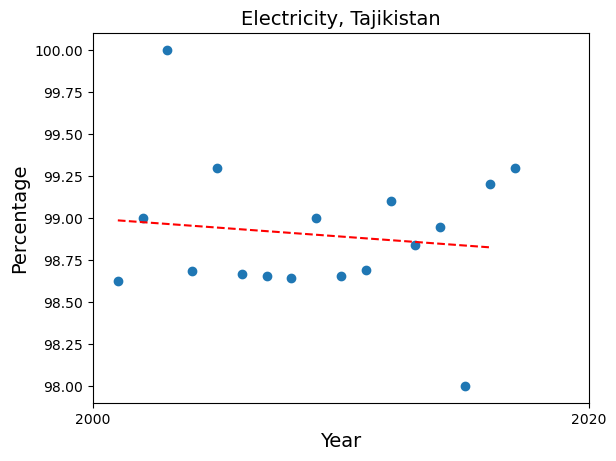

In [17]:
# Extract electricity data for Tajikistan and remove the first and last data points
y = np.array(data_df.loc[data_df['country'] == 'Tajikistan']['electricity'][1:-1])

# Extract the corresponding years and remove the first and last year
x = np.array(data_df.loc[data_df['country'] == 'Tajikistan']['year'][1:-1])

# Fit the linear function to the data
popt, _ = curve_fit(linear_function, x, y)

# Extract the fitted parameters
a, b = popt

print('y = %.5f * x + %.5f' % (a, b))

# Define a sequence of inputs between the smallest and largest known inputs
x_line = np.arange(min(x), max(x), 1)

# Calculate the output for the range
y_line = linear_function(x_line, a, b)

# Create a line plot for the mapping function
plt.plot(x_line, y_line, '--', color='red')

# Plot input vs output
plt.scatter(x, y)

plt.xticks(ticks=[2000, 2020])
plt.xlim(2000, 2020)
plt.xlabel("Year", fontsize=14)
plt.title('Electricity, Tajikistan', fontsize=14)
plt.ylabel("Percentage", fontsize=14)
plt.show()


In [18]:
country_predict_df[(country_predict_df["undernourishment"] != 0)].sort_values(by="undernourishment", ascending=False).head(20)

,electricity,women,internet,undernourishment
Japan,NaN,0.314159,0.894778,1.000000
Azerbaijan,0.640180,0.828039,0.926609,0.992095
China,0.911747,0.581754,0.975228,0.990983
Russian Federation,0.066667,0.760272,0.965549,0.990826
Sri Lanka,0.900317,0.475788,0.877789,0.986652
Ethiopia,0.566089,0.917030,0.703222,0.984418
Lao PDR,0.981776,0.806048,0.890621,0.981046
Nepal,0.983992,0.690073,0.884920,0.976848
Mongolia,0.716381,0.306106,0.754664,0.974476
Cambodia,0.901306,0.755986,0.578336,0.971364


In [19]:
...
for variable in variable_names:
    country_predict_dct[country][variable] = {}

    # Extract data for the current country and variable
    variable_data = country_evolution_df[country_filter][["year", variable]].dropna()

    # Only perform curve fitting if there are enough data points
    if len(variable_data) > 3:  # adjust this based on your requirements
        try:
            popt, pcov = curve_fit(
                f=objective,
                xdata=variable_data["year"],
                ydata=variable_data[variable]
            )
            ...
        except (ValueError, TypeError, RuntimeError):
            r_squared = None
    else:
        r_squared = None
    ...


In [20]:
country_predict_df = pd.DataFrame(goal_yr_ls_ls, columns=variable_names, index=countries)

country_predict_df.head(20)

,electricity,women,internet,undernourishment
Aruba,0.080602,NaN,0.968787,NaN
Angola,0.795406,0.587328,0.751370,0.907998
Albania,0.324554,0.905025,0.944248,0.469389
United Arab Emirates,NaN,0.691053,0.957020,0.298511
Argentina,0.969384,0.447207,0.975099,0.313747
Armenia,0.318886,0.855265,0.915172,0.747656
Antigua and Barbuda,0.150447,0.586169,0.995911,NaN
Australia,NaN,0.537486,0.969299,NaN
Austria,NaN,0.075418,0.892147,NaN
Azerbaijan,0.640180,0.828039,0.926609,0.992095


y = -155.84631 * x + 0.03888 * x^2 + 156249.69976


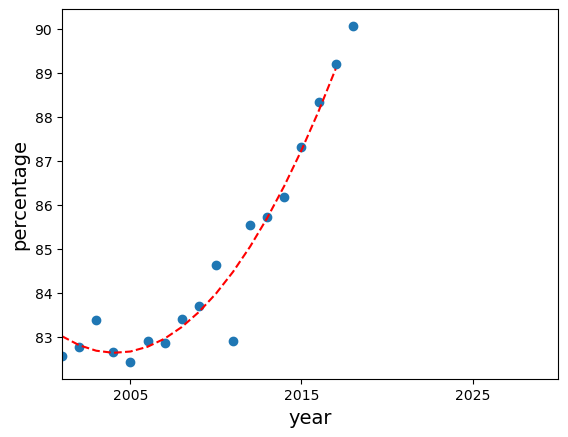

In [21]:
# Import necessary libraries

# Define quadratic function for curve fitting
def objective(x, a, b, c):
    return a * x + b * x**2 + c

# Define range of years and get corresponding electricity data
x = np.array(range(2001, 2019, 1))
y = np.array(world_evolution_df['electricity'])

# Perform curve fit with quadratic function
popt, _ = curve_fit(objective, x, y)

# Unpack fitting parameters
a, b, c = popt

# Print the equation of the fitted curve
print('y = %.5f * x + %.5f * x^2 + %.5f' % (a, b, c))

# Create a sequence of values in the range of years for plotting fitted curve
x_line = np.arange(min(x), max(x), 1)

# Calculate the predicted electricity percentages using the fitted curve
y_line = objective(x_line, a, b, c)

# Plot original data points
plt.scatter(x, y)

# Plot fitted curve
plt.plot(x_line, y_line, '--', color='red')

# Set x-axis properties
plt.xticks(ticks=[2005,2015,2025])
plt.xlim(2001,2030)
plt.xlabel("year", fontsize=14)

# Set y-axis label
plt.ylabel("percentage", fontsize=14)

# Display the plot
plt.show()


y = 0.41865 * x + -756.47535


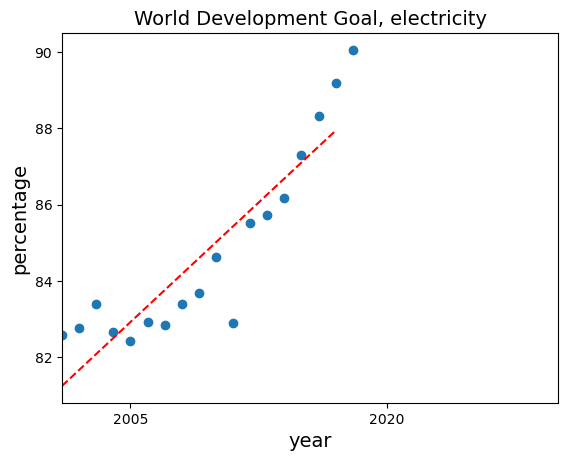

In [22]:
# Define range of years and get corresponding electricity data
x = np.array(range(2001, 2019, 1))
y = np.array(world_evolution_df['electricity'])

# Perform curve fit with linear function
popt, _ = curve_fit(linear_function, x, y)

# Unpack fitting parameters
a, b = popt

# Print the equation of the fitted curve
print('y = %.5f * x + %.5f' % (a, b))

# Create a sequence of values in the range of years for plotting fitted curve
x_line = np.arange(min(x), max(x), 1)

# Calculate the predicted electricity percentages using the fitted curve
y_line = linear_function(x_line, a, b)

# Plot original data points
plt.scatter(x, y)

# Plot fitted curve
plt.plot(x_line, y_line, '--', color='red')

# Set x-axis properties
plt.xticks(ticks=[2005, 2020])
plt.xlim(2001, 2030)
plt.xlabel("year", fontsize=14)

# Set titles
plt.title('World Development Goal, electricity', fontsize=14)

# Set y-axis label
plt.ylabel("percentage", fontsize=14)

# Display the plot
plt.show()
